#import libraries and dataset



In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import joblib
import warnings
warnings.filterwarnings('ignore')

#here i Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

#these are rwandan electricity pricing tiers (from Oct 2025)
TARIFF_RATES = {
    '0-20 kWh': 89,
    '21-50 kWh': 310,
    '50+ kWh': 369
}

# income level definitions
INCOME_LEVELS = {
    'Low': '<100,000 RWF/month',
    'Medium': '100,000-500,000 RWF/month',
    'High': '>500,000 RWF/month'
}

# Load the dataset
data = pd.read_csv('/content/rwanda_household_energy_improved.csv')
print("Dataset shape:", data.shape)
data.head(10)

Dataset shape: (13505, 14)


,Household_ID,Appliance,Power_Watts,Usage_Hours_Daily,Quantity,Usage_Days_Monthly,Region,Income_Level,Household_Size,Total_kWh_Monthly,Household_Total_kWh,Tariff_Bracket,Estimated_Bill_RWF,Month
0,HH00001,Iron,1098,0.89,1,11,Kigali,Medium,4,10.75,92.95,50+ kWh,26928.55,February
1,HH00001,Washing Machine,737,1.28,1,6,Kigali,Medium,4,5.66,92.95,50+ kWh,26928.55,February
2,HH00001,Phone Charger,6,3.06,3,29,Kigali,Medium,4,1.60,92.95,50+ kWh,26928.55,February
3,HH00001,Refrigerator,195,12.81,1,30,Kigali,Medium,4,74.94,92.95,50+ kWh,26928.55,February
4,HH00002,Water Heater,2826,1.63,1,21,Rusizi,Medium,1,96.73,119.96,50+ kWh,36895.24,October
5,HH00002,TV,134,2.84,1,28,Rusizi,Medium,1,10.66,119.96,50+ kWh,36895.24,October
6,HH00002,Electric Kettle,1197,0.50,1,21,Rusizi,Medium,1,12.57,119.96,50+ kWh,36895.24,October
7,HH00003,LED Lamp,8,4.63,3,28,West,Medium,7,3.11,116.82,50+ kWh,35736.58,March
8,HH00003,Water Heater,2630,1.56,1,26,West,Medium,7,106.67,116.82,50+ kWh,35736.58,March
9,HH00003,Rice Cooker,528,0.58,1,23,West,Medium,7,7.04,116.82,50+ kWh,35736.58,March


#Exploratory Data Analysis and Preprocessing


In [57]:
# I did check for missing values
missing_values = data.isnull().sum().reset_index()
missing_values.columns = ['Column', 'Missing_Values']
display(missing_values)

,Column,Missing_Values
0,Household_ID,0
1,Appliance,0
2,Power_Watts,0
3,Usage_Hours_Daily,0
4,Quantity,0
5,Usage_Days_Monthly,0
6,Region,0
7,Income_Level,0
8,Household_Size,0
9,Total_kWh_Monthly,0


In [58]:
# Here I did check data types
data_types = pd.DataFrame(data.dtypes, columns=['Data_Type']).reset_index()
data_types.columns = ['Column', 'Data_Type']
display(data_types)

,Column,Data_Type
0,Household_ID,object
1,Appliance,object
2,Power_Watts,int64
3,Usage_Hours_Daily,float64
4,Quantity,int64
5,Usage_Days_Monthly,int64
6,Region,object
7,Income_Level,object
8,Household_Size,int64
9,Total_kWh_Monthly,float64


In [59]:
# I did get basic statistics of the dataset
dataset_stats = data.describe().reset_index()
display(dataset_stats)

,index,Power_Watts,Usage_Hours_Daily,Quantity,Usage_Days_Monthly,Household_Size,Total_kWh_Monthly,Household_Total_kWh,Estimated_Bill_RWF
0,count,13505.000000,13505.000000,13505.000000,13505.000000,13505.000000,13505.000000,13505.000000,13505.000000
1,mean,522.631248,3.023766,1.482044,22.499593,3.965939,19.199189,78.067944,22000.636392
2,std,641.245624,2.813621,1.065185,7.913728,1.992178,25.549435,46.445827,16452.926365
3,min,5.000000,0.110000,1.000000,3.000000,1.000000,0.070000,0.730000,64.970000
4,25%,47.000000,1.180000,1.000000,20.000000,2.000000,3.690000,37.010000,7053.100000
5,50%,143.000000,2.070000,1.000000,25.000000,4.000000,9.210000,74.860000,20253.340000
6,75%,860.000000,3.890000,1.000000,28.000000,6.000000,22.180000,119.800000,36836.200000
7,max,2997.000000,17.840000,8.000000,30.000000,7.000000,189.660000,200.380000,66570.220000


In [60]:
# Here I did check for duplicates
duplicates = pd.DataFrame({'Number_of_Duplicates': [data.duplicated().sum()]})
display(duplicates)

,Number_of_Duplicates
0,0


#Data Visualization

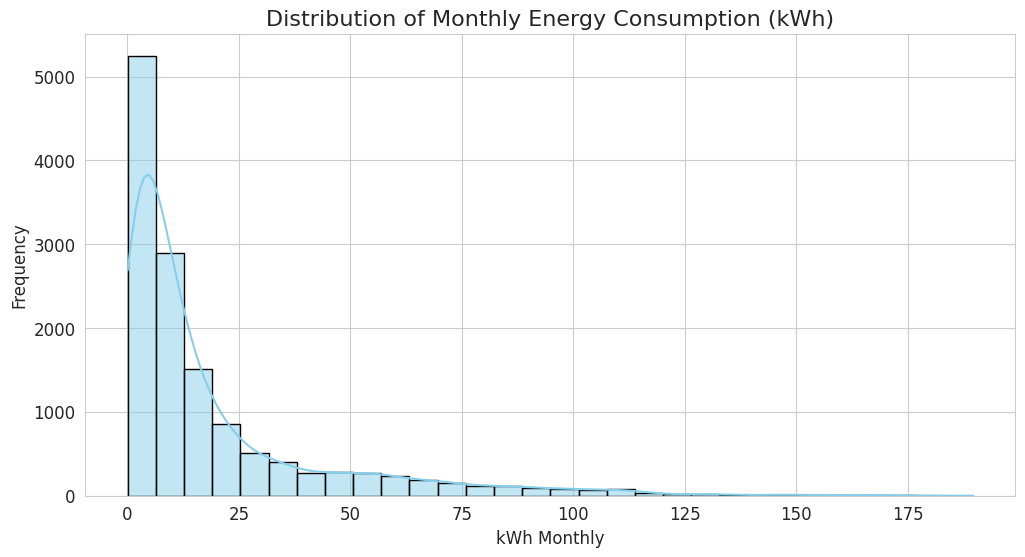

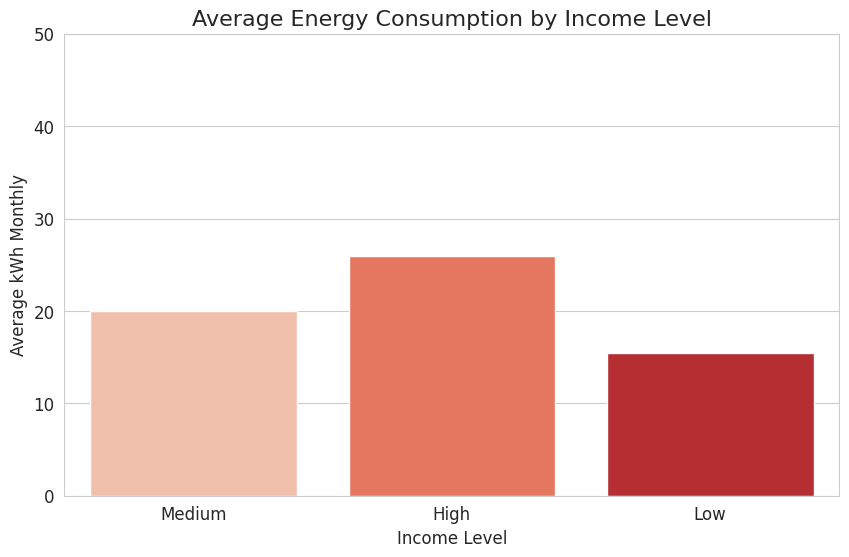

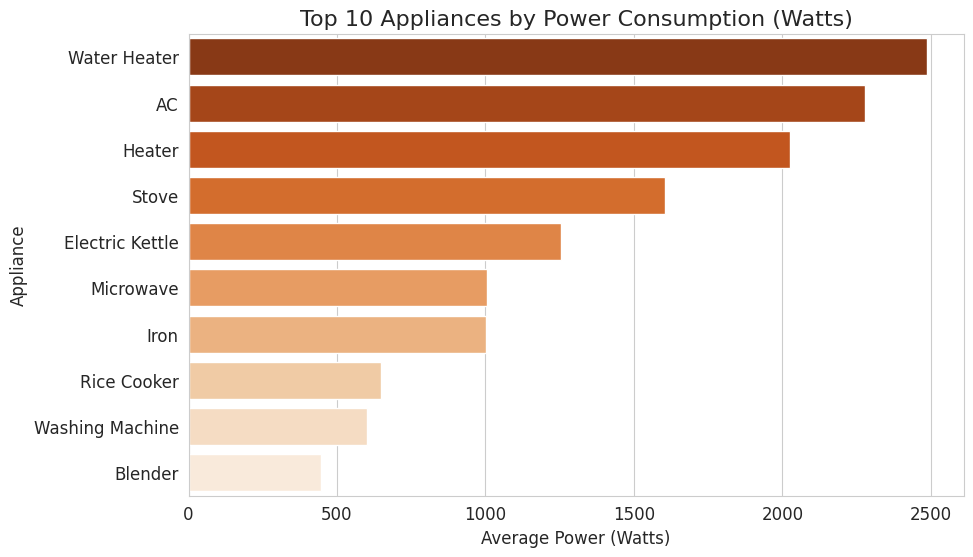

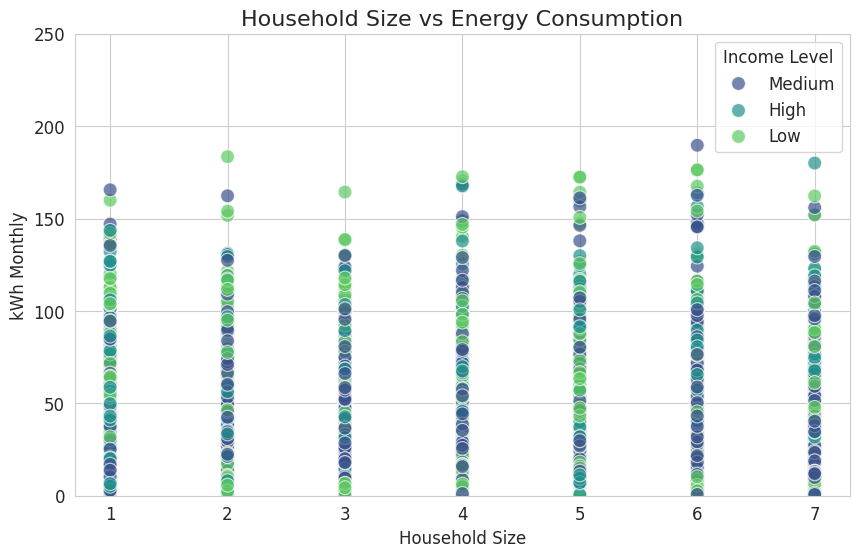

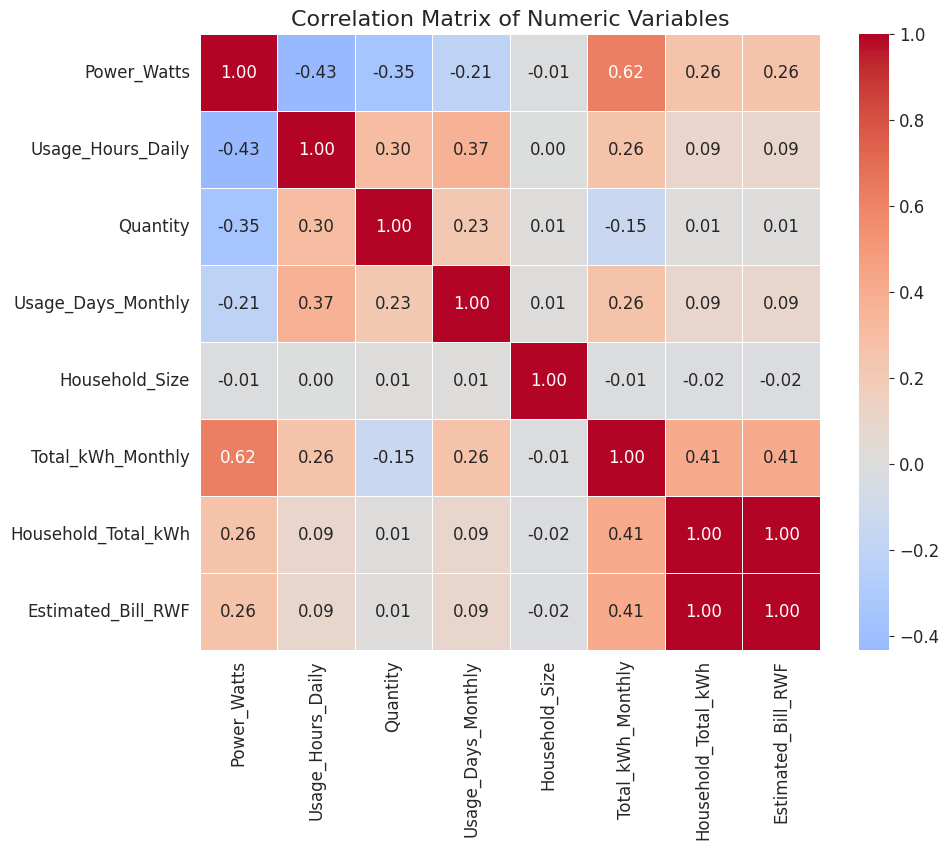

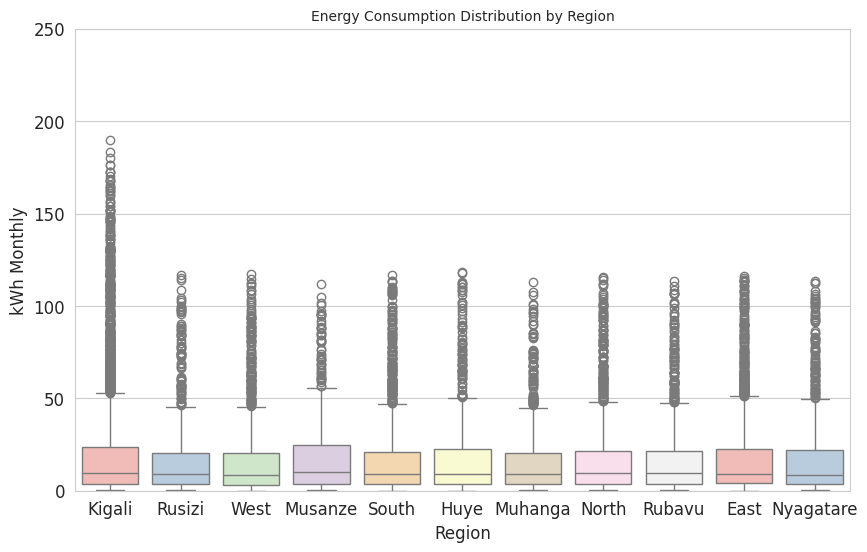

In [61]:
# Set professional style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Numeric and categorical columns
numeric_cols = data.select_dtypes(include=[np.number]).columns
categorical_cols = data.select_dtypes(include=['object', 'category']).columns

# Distribution of Monthly Energy Consumption
plt.figure(figsize=(12, 6))
sns.histplot(data['Total_kWh_Monthly'], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Monthly Energy Consumption (kWh)', fontsize=16)
plt.xlabel('kWh Monthly')
plt.ylabel('Frequency')
plt.show()

# Average Energy Consumption by Income Level
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Income_Level', y='Total_kWh_Monthly', data=data, palette='Reds', ci=None)
plt.title('Average Energy Consumption by Income Level', fontsize=16)
plt.xlabel('Income Level')
plt.ylabel('Average kWh Monthly')
ax.set_ylim([0, 50]) # Set y-axis limit
plt.show()

# Top 10 Appliances by Average Power Consumption
top_appliances = data.groupby('Appliance')['Power_Watts'].mean().sort_values(ascending=False)[:10]
plt.figure(figsize=(10, 6))
sns.barplot(x=top_appliances.values, y=top_appliances.index, palette='Oranges_r')
plt.title('Top 10 Appliances by Power Consumption (Watts)', fontsize=16)
plt.xlabel('Average Power (Watts)')
plt.ylabel('Appliance')
plt.show()

# Household Size vs Monthly Energy Consumption
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x='Household_Size', y='Total_kWh_Monthly', data=data, hue='Income_Level', palette='viridis', alpha=0.7, s=100)
plt.title('Household Size vs Energy Consumption', fontsize=16)
plt.xlabel('Household Size')
plt.ylabel('kWh Monthly')
plt.legend(title='Income Level')
ax.set_ylim([0, 250]) # Set y-axis limit
plt.show()

# Correlation Heatmap for Numeric Columns
plt.figure(figsize=(10, 8))
correlation_matrix = data[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Variables', fontsize=16)
plt.show()

# Boxplot of Consumption by Region
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='Region', y='Total_kWh_Monthly', data=data, palette='Pastel1')
plt.title('Energy Consumption Distribution by Region', fontsize=10)
plt.xlabel('Region')
plt.ylabel('kWh Monthly')
ax.set_ylim([0, 250]) # Set y-axis limit
plt.show()

#Data Preprocessing and Feature Engineering

In [53]:
# I did create a copy of the data for preprocessing
df_processed = data.copy()

# Here I did define a function to convert power to consistent units (Watts)
def ensure_watts(power_value, appliance_name=""):
    """Ensure power is in Watts"""
    # Based on typical appliance power ranges, detect if value might be in kW
    if power_value < 1 and appliance_name in ['AC', 'Water Heater', 'Refrigerator', 'Electric Kettle', 'Iron']:
        return power_value * 1000  # Convert kW to W
    return power_value

# I did apply power conversion
df_processed['Power_Watts'] = df_processed.apply(
    lambda row: ensure_watts(row['Power_Watts'], row['Appliance']), axis=1
)

# Here I did encode categorical variables
label_encoders = {}
categorical_cols = ['Region', 'Income_Level', 'Appliance', 'Tariff_Bracket','Month']

for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    label_encoders[col] = le

# I did create new features for energy calculations
df_processed['Daily_Energy_kWh'] = (df_processed['Power_Watts'] * df_processed['Usage_Hours_Daily'] * df_processed['Quantity']) / 1000
df_processed['Monthly_Usage_Factor'] = df_processed['Usage_Days_Monthly'] / 30
df_processed['Appliance_Load'] = df_processed['Power_Watts'] * df_processed['Quantity']
df_processed['Energy_Intensity'] = df_processed['Total_kWh_Monthly'] / df_processed['Household_Size']

# Here I did define features and multiple targets
X = df_processed[['Appliance', 'Power_Watts', 'Usage_Hours_Daily', 'Quantity',
                  'Region', 'Income_Level',  'Usage_Days_Monthly',
                  'Household_Size', 'Daily_Energy_kWh', 'Monthly_Usage_Factor',
                  'Appliance_Load', 'Energy_Intensity']]

# I did define multiple targets
y_kwh = df_processed['Total_kWh_Monthly']
y_tariff = df_processed['Tariff_Bracket']
y_bill = df_processed['Estimated_Bill_RWF']

# I did display shapes of features and targets
display(pd.DataFrame({
    'Features_Shape': [X.shape],
    'y_kWh_Shape': [y_kwh.shape],
    'y_Tariff_Shape': [y_tariff.shape],
    'y_Bill_Shape': [y_bill.shape]
}))

# Here I did split the data into training and test sets
X_train, X_test, y_kwh_train, y_kwh_test, y_tariff_train, y_tariff_test, y_bill_train, y_bill_test = train_test_split(
    X, y_kwh, y_tariff, y_bill, test_size=0.2, random_state=42
)

# I did scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# I did display shapes of training and test sets
display(pd.DataFrame({
    'Set': ['Training', 'Test'],
    'Features_Shape': [X_train_scaled.shape, X_test_scaled.shape]
}))

,Features_Shape,y_kWh_Shape,y_Tariff_Shape,y_Bill_Shape
0,"(11000, 12)","(11000,)","(11000,)","(11000,)"


,Set,Features_Shape
0,Training,"(8800, 12)"
1,Test,"(2200, 12)"


#Build and Train the Neural Network Model

In [54]:
# I did define a function to build a multi-output neural network model
def create_multi_output_model(input_shape):
    """Create a neural network with multiple outputs"""

    # Here I did define the input layer
    inputs = keras.Input(shape=(input_shape,))

    # I did create shared hidden layers
    x = layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001))(inputs)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = layers.Dropout(0.2)(x)

    # I did define separate output layers

    # Output 1: kWh prediction (regression)
    kwh_output = layers.Dense(32, activation='relu')(x)
    kwh_output = layers.Dense(1, name='kwh_output')(kwh_output)

    # Output 2: Tariff bracket prediction (classification)
    tariff_output = layers.Dense(32, activation='relu')(x)
    tariff_output = layers.Dense(3, activation='softmax', name='tariff_output')(tariff_output)

    # Output 3: Bill amount prediction (regression)
    bill_output = layers.Dense(32, activation='relu')(x)
    bill_output = layers.Dense(1, name='bill_output')(bill_output)

    # Here I did create the model object
    model = keras.Model(inputs=inputs, outputs=[kwh_output, tariff_output, bill_output])

    return model

# I did create the model
model = create_multi_output_model(X_train_scaled.shape[1])

# Here I did compile the model with different loss functions and metrics for each output
model.compile(
    optimizer='adam',
    loss={
        'kwh_output': 'mse',
        'tariff_output': 'sparse_categorical_crossentropy',
        'bill_output': 'mse'
    },
    loss_weights={
        'kwh_output': 0.4,
        'tariff_output': 0.3,
        'bill_output': 0.3
    },
    metrics={
        'kwh_output': ['mae'],
        'tariff_output': ['accuracy'],
        'bill_output': ['mae']
    }
)

# I did display the model architecture
model.summary()

# Here I did define early stopping callback
early_stopping = keras.callbacks.EarlyStopping(
    patience=25,
    min_delta=0.001,
    restore_best_weights=True,
    verbose=1
)

# Here I did define learning rate reduction callback
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    factor=0.5,
    patience=10,
    min_lr=0.0001,
    verbose=1
)

# I did train the model with multiple outputs and validation data
history = model.fit(
    X_train_scaled,
    {
        'kwh_output': y_kwh_train,
        'tariff_output': y_tariff_train,
        'bill_output': y_bill_train
    },
    validation_data=(
        X_test_scaled,
        {
            'kwh_output': y_kwh_test,
            'tariff_output': y_tariff_test,
            'bill_output': y_bill_test
        }
    ),
    epochs=200,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │      3,328 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     32,896 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 32)        │      2,080 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 32)        │      2,080 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 32)        │      2,080 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ kwh_output (Dense)  │ (None, 1)         │         33 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tariff_output       │ (None, 3)         │         99 │ dense_10[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bill_output (Dense) │ (None, 1)         │         33 │ dense_11[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 50,885 (198.77 KB)

 Trainable params: 50,885 (198.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - bill_output_loss: 11206051840.0000 - bill_output_mae: 52928.0977 - kwh_output_loss: 72983.3125 - kwh_output_mae: 145.8527 - loss: 3361974528.0000 - tariff_output_accuracy: 0.4600 - tariff_output_loss: 2.5948 - val_bill_output_loss: 3100625408.0000 - val_bill_output_mae: 28713.9531 - val_kwh_output_loss: 16117.8018 - val_kwh_output_mae: 66.0748 - val_loss: 940299712.0000 - val_tariff_output_accuracy: 0.4200 - val_tariff_output_loss: 23.8707 - learning_rate: 0.0010
Epoch 2/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - bill_output_loss: 1174066304.0000 - bill_output_mae: 19329.2051 - kwh_output_loss: 26469.6855 - kwh_output_mae: 78.3789 - loss: 352241152.0000 - tariff_output_accuracy: 0.4279 - tariff_output_loss: 25.7857 - val_bill_output_loss: 509469440.0000 - val_bill_output_mae: 13820.4580 - val_kwh_output_loss: 4513.0176 - val_kwh_output_mae: 39.2361 - val_loss: 152037680.0000 - val_tariff_output_accuracy: 0.5232 - val_tariff_o

#Model Evaluation

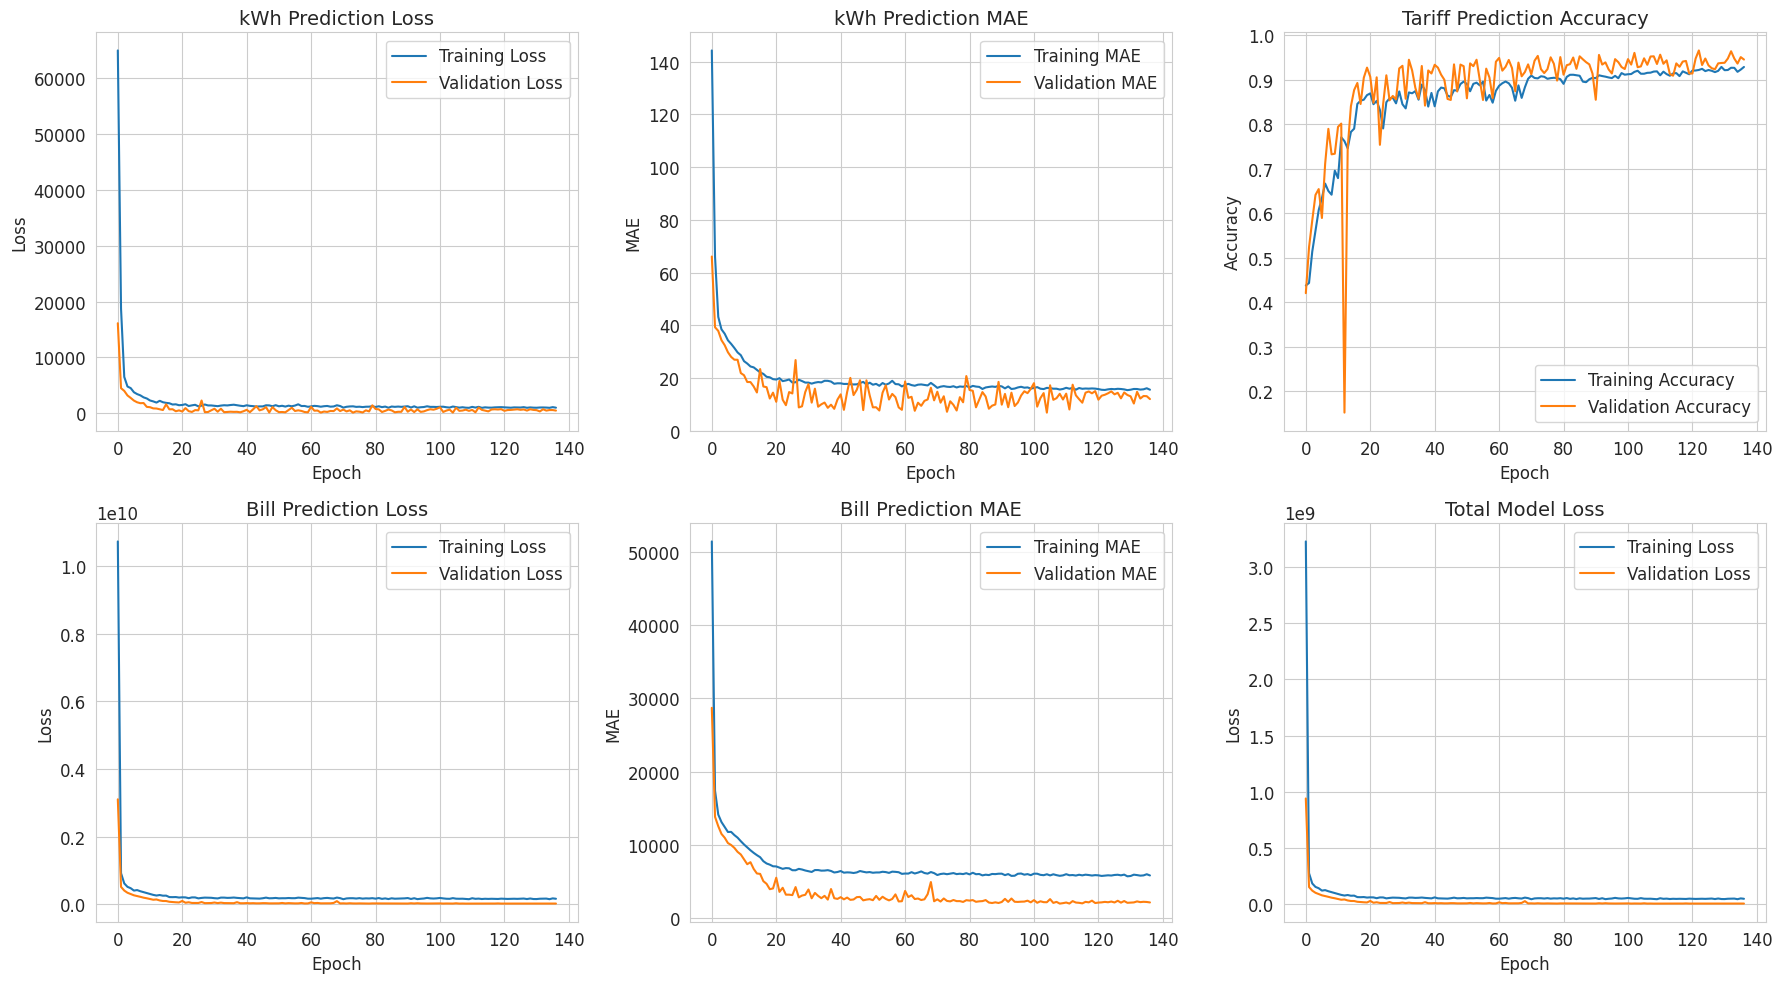

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MODEL EVALUATION RESULTS
kWh Prediction Metrics:
MAE: 8.03 kWh
RMSE: 14.34 kWh
R²: 0.9968

Tariff Bracket Prediction Metrics:
Accuracy: 0.9359
Precision: 0.9360
Recall: 0.9359
F1-Score: 0.9329

Bill Prediction Metrics:
MAE: 1978.65 RWF
RMSE: 3837.04 RWF
R²: 0.9983


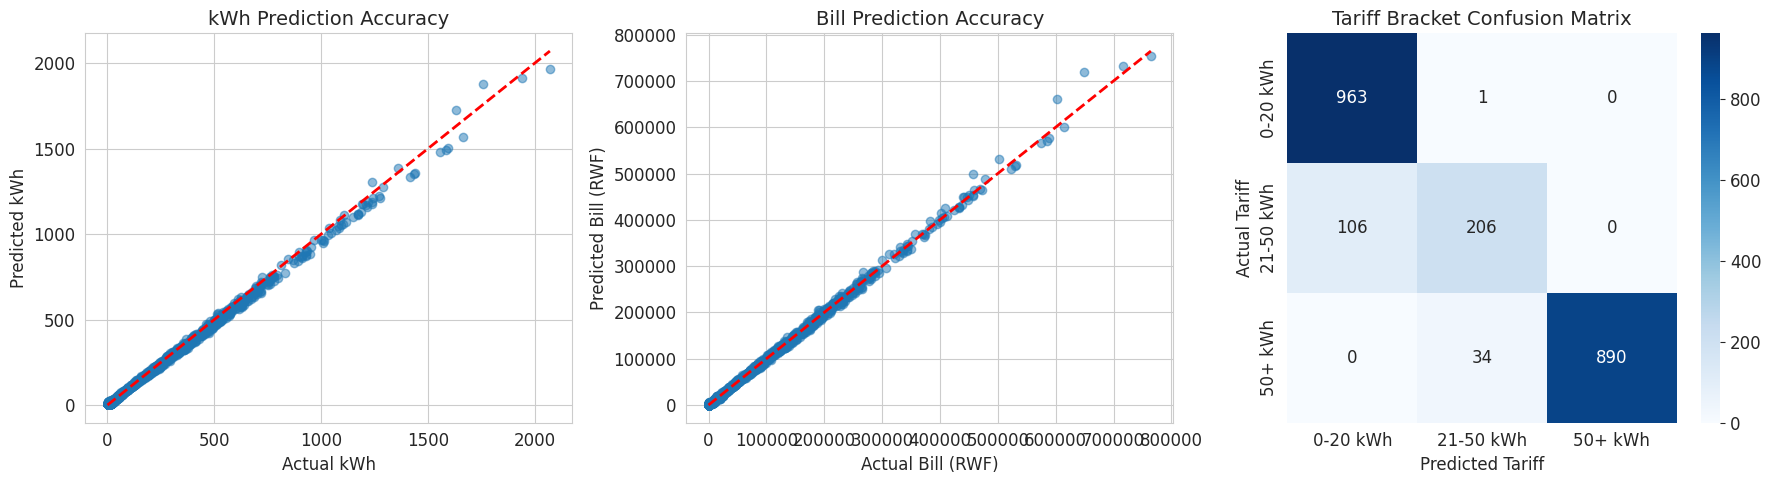

In [55]:
# Plot training history
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# kWh loss
axes[0, 0].plot(history.history['kwh_output_loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_kwh_output_loss'], label='Validation Loss')
axes[0, 0].set_title('kWh Prediction Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# kWh MAE
axes[0, 1].plot(history.history['kwh_output_mae'], label='Training MAE')
axes[0, 1].plot(history.history['val_kwh_output_mae'], label='Validation MAE')
axes[0, 1].set_title('kWh Prediction MAE')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].legend()

# Tariff accuracy
axes[0, 2].plot(history.history['tariff_output_accuracy'], label='Training Accuracy')
axes[0, 2].plot(history.history['val_tariff_output_accuracy'], label='Validation Accuracy')
axes[0, 2].set_title('Tariff Prediction Accuracy')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Accuracy')
axes[0, 2].legend()

# Bill loss
axes[1, 0].plot(history.history['bill_output_loss'], label='Training Loss')
axes[1, 0].plot(history.history['val_bill_output_loss'], label='Validation Loss')
axes[1, 0].set_title('Bill Prediction Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()

# Bill MAE
axes[1, 1].plot(history.history['bill_output_mae'], label='Training MAE')
axes[1, 1].plot(history.history['val_bill_output_mae'], label='Validation MAE')
axes[1, 1].set_title('Bill Prediction MAE')
axes[1, 1].set_ylabel('MAE')
axes[1, 1].legend()

# Total loss
axes[1, 2].plot(history.history['loss'], label='Training Loss')
axes[1, 2].plot(history.history['val_loss'], label='Validation Loss')
axes[1, 2].set_title('Total Model Loss')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Loss')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

# Make predictions
y_pred_kwh, y_pred_tariff_proba, y_pred_bill = model.predict(X_test_scaled)

# Convert tariff probabilities to class predictions
y_pred_tariff = np.argmax(y_pred_tariff_proba, axis=1)

# Flatten regression outputs
y_pred_kwh = y_pred_kwh.flatten()
y_pred_bill = y_pred_bill.flatten()

# Calculate evaluation metrics
print("MODEL EVALUATION RESULTS")
print("=" * 50)

# kWh prediction metrics
kwh_mae = mean_absolute_error(y_kwh_test, y_pred_kwh)
kwh_mse = mean_squared_error(y_kwh_test, y_pred_kwh)
kwh_rmse = np.sqrt(kwh_mse)
kwh_r2 = r2_score(y_kwh_test, y_pred_kwh)

print(f"kWh Prediction Metrics:")
print(f"MAE: {kwh_mae:.2f} kWh")
print(f"RMSE: {kwh_rmse:.2f} kWh")
print(f"R²: {kwh_r2:.4f}")

# Tariff prediction metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

tariff_accuracy = accuracy_score(y_tariff_test, y_pred_tariff)
tariff_precision = precision_score(y_tariff_test, y_pred_tariff, average='weighted')
tariff_recall = recall_score(y_tariff_test, y_pred_tariff, average='weighted')
tariff_f1 = f1_score(y_tariff_test, y_pred_tariff, average='weighted')

print(f"\nTariff Bracket Prediction Metrics:")
print(f"Accuracy: {tariff_accuracy:.4f}")
print(f"Precision: {tariff_precision:.4f}")
print(f"Recall: {tariff_recall:.4f}")
print(f"F1-Score: {tariff_f1:.4f}")


# Bill prediction metrics
bill_mae = mean_absolute_error(y_bill_test, y_pred_bill)
bill_mse = mean_squared_error(y_bill_test, y_pred_bill)
bill_rmse = np.sqrt(bill_mse)
bill_r2 = r2_score(y_bill_test, y_pred_bill)

print(f"\nBill Prediction Metrics:")
print(f"MAE: {bill_mae:.2f} RWF")
print(f"RMSE: {bill_rmse:.2f} RWF")
print(f"R²: {bill_r2:.4f}")

# Plot predictions vs actual values
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# kWh predictions
axes[0].scatter(y_kwh_test, y_pred_kwh, alpha=0.5)
axes[0].plot([y_kwh_test.min(), y_kwh_test.max()], [y_kwh_test.min(), y_kwh_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual kWh')
axes[0].set_ylabel('Predicted kWh')
axes[0].set_title('kWh Prediction Accuracy')

# Bill predictions
axes[1].scatter(y_bill_test, y_pred_bill, alpha=0.5)
axes[1].plot([y_bill_test.min(), y_bill_test.max()], [y_bill_test.min(), y_bill_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Bill (RWF)')
axes[1].set_ylabel('Predicted Bill (RWF)')
axes[1].set_title('Bill Prediction Accuracy')

# Tariff confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_tariff_test, y_pred_tariff)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[2],
            xticklabels=label_encoders['Tariff_Bracket'].classes_,
            yticklabels=label_encoders['Tariff_Bracket'].classes_)
axes[2].set_xlabel('Predicted Tariff')
axes[2].set_ylabel('Actual Tariff')
axes[2].set_title('Tariff Bracket Confusion Matrix')

plt.tight_layout()
plt.show()